In [3]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.3.0


In [4]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [6]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [7]:
# Start by doing the WRONG thing - trying to predict the price itself
series = df['close'].values.reshape(-1, 1)

In [8]:
series[:5]

array([[28.185],
       [28.07 ],
       [28.13 ],
       [27.915],
       [27.775]])

In [9]:
# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [10]:
series[:5]

array([-1.62500489, -1.64174953, -1.6330132 , -1.66431839, -1.68470317])

In [11]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [12]:
X[0]

array([[-1.62500489],
       [-1.64174953],
       [-1.6330132 ],
       [-1.66431839],
       [-1.68470317],
       [-1.77279453],
       [-1.76478623],
       [-1.84778139],
       [-1.84486928],
       [-1.78517101]])

In [13]:
Y[0]

-1.8550616725763345

In [14]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 1s 27ms/step - loss: 0.1140 - val_loss: 0.0822
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0549
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0189
Epoch 4/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0143
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0139
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0262
Epoch 7/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0381
Epoch 8/80
20/20 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0215
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0159
Epoch 10/80
20/20 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0252
Epoch 11/80
20/20 

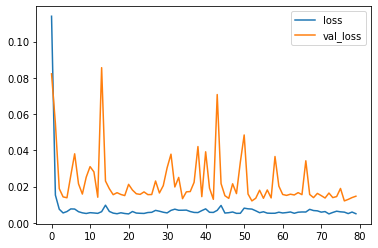

In [15]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


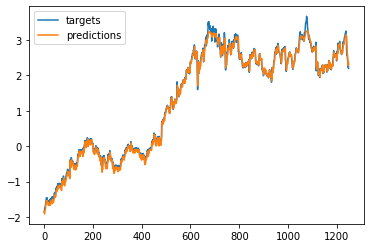

In [16]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

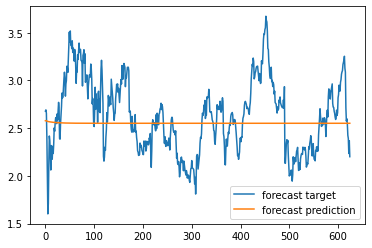

In [17]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [18]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now it's like
# close / prev close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [19]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [21]:
# then the return is
# (x[t] - x[t-1]) / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

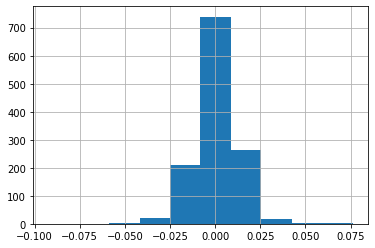

In [22]:
# Now let's try an LSTM to predict returns
df['Return'].hist()

In [23]:
series = df['Return'].values[1:].reshape(-1, 1)

# Normalize the data
# Note: I didn't think about where the true boundary is, this is just approx.
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [24]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1248, 10, 1) Y.shape (1248,)


In [25]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 0s 24ms/step - loss: 0.9905 - val_loss: 1.1489
Epoch 2/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9893 - val_loss: 1.1429
Epoch 3/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9849 - val_loss: 1.1438
Epoch 4/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9844 - val_loss: 1.1480
Epoch 5/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9813 - val_loss: 1.1533
Epoch 6/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9823 - val_loss: 1.1472
Epoch 7/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9868 - val_loss: 1.1512
Epoch 8/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9783 - val_loss: 1.1523
Epoch 9/80
20/20 [==============================] - 0s 6ms/step - loss: 0.9802 - val_loss: 1.1510
Epoch 10/80
20/20 [==============================] - 0s 7ms/step - loss: 0.9747 - val_loss: 1.1646
Epoch 11/80
20/20 

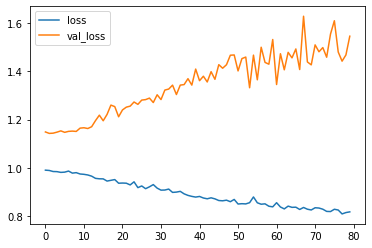

In [26]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


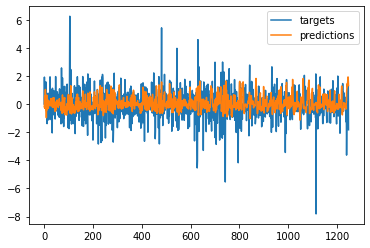

In [27]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

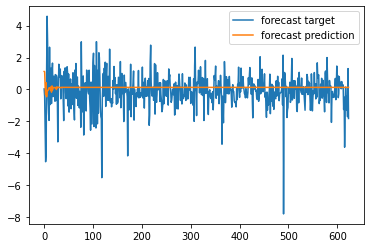

In [28]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [30]:
# Now turn the full data into numpy arrays

# Not yet in the final "X" format!
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [40]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g. if T=10 and you have 11 data points then you'd only have 1 sample)

In [31]:
input_data.shape

(1259, 5)

In [32]:
N = len(input_data) - T

In [33]:
N

1249

In [39]:
# normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [36]:
input_data.shape
Ntrain

839

In [41]:
# Setup X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [42]:
# Setup X_test and Y_test
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

In [44]:
# make the RNN
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy'],
)

In [45]:
# train the RNN
r = model.fit(
  X_train, Y_train,
  batch_size=32,
  epochs=300,
  validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 1s 22ms/step - loss: 0.6966 - accuracy: 0.4899 - val_loss: 0.6952 - val_accuracy: 0.4805
Epoch 2/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5030 - val_loss: 0.6938 - val_accuracy: 0.5024
Epoch 3/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.5268 - val_loss: 0.6983 - val_accuracy: 0.4854
Epoch 4/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5280 - val_loss: 0.6980 - val_accuracy: 0.4854
Epoch 5/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5185 - val_loss: 0.6959 - val_accuracy: 0.4854
Epoch 6/300
27/27 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5089 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 7/300
27/27 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5018 - val_loss: 0.6941 - val_accuracy: 0.4927
Epoch 8/300


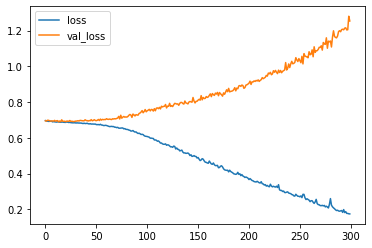

In [46]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

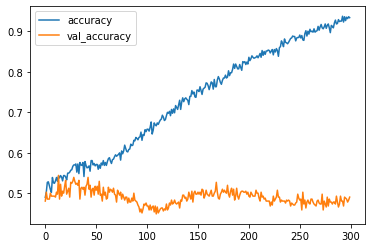

In [47]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()